In [1]:
!pip install torch torchvision torchaudio
!pip install transformers[torch]
!pip install transformers
!pip install accelerate -U


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [11]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 19.0 MB/s eta 0:00:00


In [20]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
import transformers
import torch
import accelerate
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report
from torch.nn import CrossEntropyLoss
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import torch, torch.utils.data
from nltk.stem import WordNetLemmatizer
import nltk
from contractions import fix
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd drive/MyDrive/Cs412/project_files

/content/drive/MyDrive/Cs412/project_files


In [13]:
train_df = pd.read_csv('bugs-train.csv')
test_df = pd.read_csv('bugs-test.csv')

In [14]:
# Display the first few rows of the training dataset
print("First few rows of the training dataset:")
print(train_df.head())

# Check for class imbalance in the training set
severity_counts = train_df['severity'].value_counts()
print("\nDistribution of Bug Severity in Training Set:")
print(severity_counts)

First few rows of the training dataset:
   bug_id                                            summary  severity
0  365569                  Remove workaround from bug 297227    normal
1  365578    Print Preview crashes on any URL in gtk2 builds  critical
2  365582                     Lines are not showing in table     major
3  365584  Firefox render ÛÏsimplified ArabicÛ font fa...    normal
4  365597             Crash [@ nsINodeInfo::NodeInfoManager]  critical

Distribution of Bug Severity in Training Set:
severity
normal         125854
critical        18658
major            6053
enhancement      4426
minor            3102
trivial          1204
blocker           701
Name: count, dtype: int64


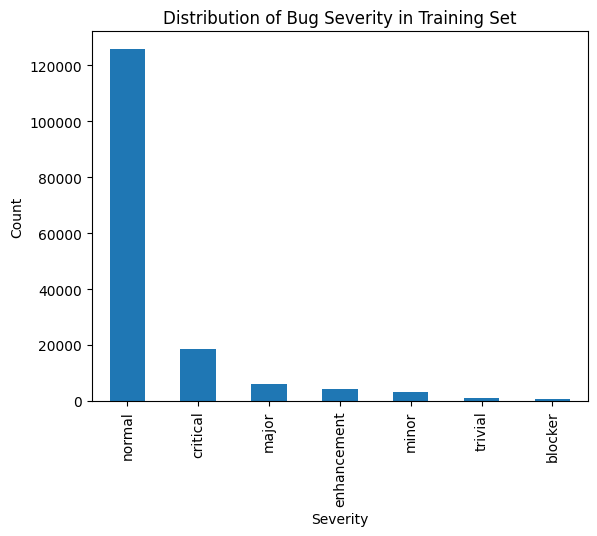

In [15]:
# Plot the distribution of bug severity in the training set
severity_counts.plot(kind='bar')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.title('Distribution of Bug Severity in Training Set')
plt.show()


In [17]:
def clean_text(text):
  # Expand contractions
    text = fix(text)
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
     # Lemmatize words
    words = text.split()
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

In [ ]:
# Function to check if a string contains only English characters
def is_english(s):
    return bool(re.match(r'^[\x00-\x7F]+$', s))

# Remove rows with non-English characters in the 'summary' column
train_df = train_df[train_df['summary'].apply(clean_text)]

# Check for missing values and drop them
train_df = train_df.dropna()
print(train_df.head())

# Split data into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['severity'], random_state=42)

train_df.shape, val_df.shape

In [9]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize summaries
train_encodings = tokenizer(train_df['summary'].tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_df['summary'].tolist(), truncation=True, padding=True, max_length=128)

train_encodings.keys()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [17]:
# Convert labels to numeric data
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['severity'])
val_labels = label_encoder.transform(val_df['severity'])


In [18]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [19]:
# Custom dataset class
class BugDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [20]:
# Create dataset objects
train_dataset = BugDataset(train_encodings, train_labels)
val_dataset = BugDataset(val_encodings, val_labels)

In [21]:

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [23]:
training_args = TrainingArguments(
    output_dir= './results',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    fp16=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [34]:


# Define compute_metrics function using classification_report
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    report = classification_report(labels, preds, output_dict=True)
    return {
        'accuracy': report['accuracy'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score']
    }

# Custom Trainer class to incorporate class weights
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss
# Trainer
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)


In [25]:
# Check if GPU is available
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
else:
    print("CUDA is not available. Training on CPU.")


CUDA is available. Training on GPU.


In [36]:

# Train the model
trainer.train()

<ipython-input-113-2eab11771b5d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Macro Precision,Macro Recall,Macro F1
1,1.321800,0.530257,0.857344,0.813171,0.857344,0.821038,0.455066,0.274682,0.284189
2,1.173700,0.521718,0.857617,0.816676,0.857617,0.821376,0.480243,0.275197,0.288170
3,1.064800,0.524555,0.858555,0.821448,0.858555,0.823279,0.517976,0.284311,0.303302


<ipython-input-113-2eab11771b5d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-113-2eab11771b5d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


TrainOutput(global_step=13215, training_loss=1.2248807701431257, metrics={'train_runtime': 3645.1084, 'train_samples_per_second': 464.037, 'train_steps_per_second': 3.625, 'total_flos': 7.041041812304011e+16, 'train_loss': 1.2248807701431257, 'epoch': 3.0})

In [ ]:

# Evaluate the model
eval_result = trainer.evaluate()
print(f"Evaluation result: {eval_result}")

# Tokenize test data
test_encodings = tokenizer(test_df['summary'].tolist(), truncation=True, padding=True, max_length=128)

# Create test dataset
test_dataset = BugDataset(test_encodings, [0] * len(test_df))  # Dummy labels since we don't have them

# Predict labels for test data
test_predictions = trainer.predict(test_dataset)

# Convert numeric labels back to original labels
predicted_labels = label_encoder.inverse_transform(np.argmax(test_predictions.predictions, axis=1))

# Prepare submission file
submission_df = pd.DataFrame({'bug_id': test_df['bug_id'], 'predicted_label': predicted_labels})
submission_df.to_csv('submission.csv', index=False)